# Dask with PyROOT example
---
This example notebook shows how one can use Dask to process flat ntuples in parallel using PyROOT.
Each job fills some histograms which are retrieved and then drawn together at the end.

### Import modules
---

In [1]:
import ROOT
import time

Welcome to JupyROOT 6.22/00


### Set up sample paths to input files and tree names
---

In [2]:
# Dictionary for samples with following format
# key=sample_name, value = (file_name,tree_name)

sample_dict = {
    "signal" : ("input/signal.root","signal"),
    "background1" : ("input/background1.root","background1"),
    "background2" : ("input/background2.root","background2"),
}

input_list = list(sample_dict.items())
print(input_list)

[('signal', ('input/signal.root', 'signal')), ('background1', ('input/background1.root', 'background1')), ('background2', ('input/background2.root', 'background2'))]


### Function to be executed for each job
---

In [3]:
def process_with_pyroot(my_input):
    # expected format for my_input
    # ( sample_name,(file_name,tree_name) )
    sample_name = my_input[0]
    file_name = my_input[1][0]
    tree_name = my_input[1][1]
    print("Processing sample {} at {} with tree {}".format(sample_name,file_name,tree_name))
    
    import ROOT
    import time
    
    time_start = time.perf_counter()
    
    outputhists = {
        "met_Et_raw": ROOT.TH1D("met_Et_raw",";E_{T}^{miss}",40,0,1000),
        "nAjets_raw": ROOT.TH1D("nAjets_raw",";jet multiplicity",10,0,10),
    }

    infile = ROOT.TFile.Open(file_name,"READ")
    t = infile.Get(tree_name)
    
    total_raw = t.GetEntries()
    print( "Processing {} raw events".format(total_raw) )
    
    for i in range(total_raw):
        if i>0 and not i%10000:
            time_elapsed = time.perf_counter() - time_start
            print( "Processed {} / {} events at {} events/s".format(i,total_raw,i/time_elapsed) )
        t.GetEntry(i)
        
        event_weight = 1
        
        outputhists["met_Et_raw"].Fill(t.met_Et,event_weight)
        outputhists["nAjets_raw"].Fill(t.nAjets,event_weight)

    infile.Close()
    
    # Return the sample name and histograms to be retrieved
    return sample_name, outputhists

### Set up Dask for SLURM cluster
---

In [ ]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    walltime='01:00:00',
    queue='shared',
    project="myproj",
    cores=1,
    memory="1 GB",
    python="/usr/bin/python3",
    job_extra=['--account=shared', '--partition=shared']
)
# Set number of workers to the number of samples
n_workers = len(input_list)
max_workers = 8
if n_workers > max_workers:
    n_workers = max_workers
cluster.scale(n_workers)
print(cluster.job_script())

from dask.distributed import Client
client = Client(cluster)
client.wait_for_workers(n_workers)

### You can use the dashboard link to monitor your jobs and workers
---

In [ ]:
client

### Execute your function in parallel for each sample and then retrieve the results
---

In [6]:
futures = client.map(process_with_pyroot, input_list)
res = client.gather(futures)
res

[('signal',
  {'met_Et_raw': <cppyy.gbl.TH1D object at 0x7fc768bac330>,
   'nAjets_raw': <cppyy.gbl.TH1D object at 0x7fc768bac720>}),
 ('background1',
  {'met_Et_raw': <cppyy.gbl.TH1D object at 0x7fc768bacbf0>,
   'nAjets_raw': <cppyy.gbl.TH1D object at 0x7fc768ba92d0>}),
 ('background2',
  {'met_Et_raw': <cppyy.gbl.TH1D object at 0x7fc768a3b250>,
   'nAjets_raw': <cppyy.gbl.TH1D object at 0x7fc768babf40>})]

### Plot the histograms for each sample together
---

In [7]:
ROOT.gStyle.SetPalette(ROOT.kRainBow)
ROOT.gStyle.SetOptStat(0)
c = ROOT.TCanvas("c","c",800,600)
pad1 = ROOT.TPad("pad1", "pad1",0.0,0.0,0.8,1.0)
pad2 = ROOT.TPad("pad2", "pad2",0.8,0.0,1.0,1.0)
pad1.Draw()
pad2.Draw()

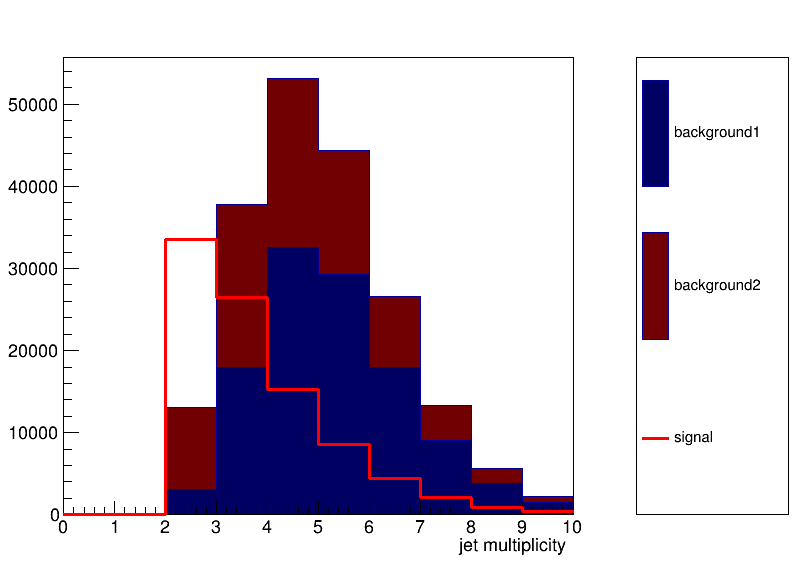

In [12]:
var = "nAjets_raw" # which histogram to plot
c.cd()
hs = ROOT.THStack("hs","hs")
legend = ROOT.TLegend(0.0,0.1,0.95,0.9)

h_background1 = dict(res)["background1"][var]
hs.Add(h_background1)
legend.AddEntry(h_background1,"background1","f")

h_background2 = dict(res)["background2"][var]
hs.Add(h_background2)
legend.AddEntry(h_background2,"background2","f")

pad1.cd()
hs.Draw("pfc hist")
hs.GetXaxis().SetTitle( h_background1.GetXaxis().GetTitle() )
hs.SetTitle("")

h_signal = dict(res)["signal"][var]
h_signal.SetLineColor(2)
h_signal.SetLineWidth(3)
pad1.cd()
h_signal.Draw("sames hist")
legend.AddEntry(h_signal,"signal","l")

pad2.cd()
legend.SetTextSize(0.1)
legend.Draw()

c.Draw()

### Shutdown the workers and close the Dask client
---

In [9]:
# client.shutdown()
# client.close()